# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 6.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [45]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.3 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.3 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [46]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [47]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [48]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [49]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.3), constraint=constraints.positive)
    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.3), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [50]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [51]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [52]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [53]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [54]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [55]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [56]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [57]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-54-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 7/5000 [00:00<01:20, 62.28it/s]

Step 0 : loss = 5429122.260417427


  2%|▏         | 108/5000 [00:01<01:14, 65.82it/s]

Step 100 : loss = 1982582.2453300008


  4%|▍         | 211/5000 [00:03<01:10, 67.87it/s]

Step 200 : loss = 1893551.2257858769


  6%|▋         | 315/5000 [00:04<01:06, 70.33it/s]

Step 300 : loss = 1876058.494252603


  8%|▊         | 410/5000 [00:05<01:05, 70.54it/s]

Step 400 : loss = 1842958.807919254


 10%|█         | 512/5000 [00:07<01:05, 68.31it/s]

Step 500 : loss = 1838548.998895459


 12%|█▏        | 612/5000 [00:08<01:03, 69.45it/s]

Step 600 : loss = 1816769.9237263382


 14%|█▍        | 711/5000 [00:10<01:25, 49.96it/s]

Step 700 : loss = 1810619.2122208057


 16%|█▋        | 814/5000 [00:12<01:16, 54.91it/s]

Step 800 : loss = 1815473.802227028


 18%|█▊        | 914/5000 [00:14<00:59, 68.38it/s]

Step 900 : loss = 1811539.6783449827


 20%|██        | 1009/5000 [00:15<00:57, 69.48it/s]

Step 1000 : loss = 1808932.2956219888


 22%|██▏       | 1111/5000 [00:16<00:53, 73.06it/s]

Step 1100 : loss = 1815963.1380515099


 24%|██▍       | 1211/5000 [00:18<00:53, 70.29it/s]

Step 1200 : loss = 1813402.6672479112


 26%|██▌       | 1309/5000 [00:20<00:57, 64.14it/s]

Step 1300 : loss = 1805891.286623051


 28%|██▊       | 1410/5000 [00:21<00:54, 65.96it/s]

Step 1400 : loss = 1795264.4027591536


 30%|███       | 1508/5000 [00:23<01:04, 53.78it/s]

Step 1500 : loss = 1822502.9121505963


 32%|███▏      | 1610/5000 [00:25<01:07, 50.39it/s]

Step 1600 : loss = 1799438.0845088137


 34%|███▍      | 1715/5000 [00:26<00:47, 69.19it/s]

Step 1700 : loss = 1803844.9638654257


 36%|███▌      | 1810/5000 [00:28<00:43, 73.03it/s]

Step 1800 : loss = 1791234.8364783258


 38%|███▊      | 1914/5000 [00:29<00:44, 69.89it/s]

Step 1900 : loss = 1811694.5057709606


 40%|████      | 2008/5000 [00:31<00:42, 70.39it/s]

Step 2000 : loss = 1801268.4122459805


 42%|████▏     | 2112/5000 [00:32<00:39, 72.30it/s]

Step 2100 : loss = 1795661.3018180171


 44%|████▍     | 2208/5000 [00:33<00:40, 69.78it/s]

Step 2200 : loss = 1800343.049883733


 46%|████▌     | 2312/5000 [00:35<00:37, 72.28it/s]

Step 2300 : loss = 1805628.0309475898


 48%|████▊     | 2406/5000 [00:36<00:51, 50.76it/s]

Step 2400 : loss = 1790630.6562452787


 50%|█████     | 2512/5000 [00:39<00:44, 56.54it/s]

Step 2500 : loss = 1790449.6892115755


 52%|█████▏    | 2615/5000 [00:40<00:33, 71.92it/s]

Step 2600 : loss = 1787947.517241631


 54%|█████▍    | 2710/5000 [00:41<00:32, 70.16it/s]

Step 2700 : loss = 1809766.8705422333


 56%|█████▋    | 2814/5000 [00:43<00:30, 72.45it/s]

Step 2800 : loss = 1803601.586220088


 58%|█████▊    | 2913/5000 [00:44<00:30, 68.59it/s]

Step 2900 : loss = 1793713.9239881453


 60%|██████    | 3014/5000 [00:46<00:28, 69.20it/s]

Step 3000 : loss = 1803928.39056678


 62%|██████▏   | 3113/5000 [00:47<00:26, 70.40it/s]

Step 3100 : loss = 1794009.1174856476


 64%|██████▍   | 3207/5000 [00:48<00:26, 66.50it/s]

Step 3200 : loss = 1806649.1462137746


 66%|██████▌   | 3311/5000 [00:50<00:32, 51.60it/s]

Step 3300 : loss = 1808426.2842267153


 68%|██████▊   | 3412/5000 [00:52<00:23, 67.59it/s]

Step 3400 : loss = 1809823.584331334


 70%|███████   | 3514/5000 [00:54<00:20, 73.90it/s]

Step 3500 : loss = 1800371.3885952497


 72%|███████▏  | 3610/5000 [00:55<00:18, 73.68it/s]

Step 3600 : loss = 1805649.678533141


 74%|███████▍  | 3712/5000 [00:56<00:18, 69.50it/s]

Step 3700 : loss = 1814098.40229769


 76%|███████▋  | 3815/5000 [00:58<00:16, 72.88it/s]

Step 3800 : loss = 1811206.960423482


 78%|███████▊  | 3911/5000 [00:59<00:15, 71.29it/s]

Step 3900 : loss = 1807073.2668904825


 80%|████████  | 4015/5000 [01:01<00:13, 72.91it/s]

Step 4000 : loss = 1791768.943133553


 82%|████████▏ | 4109/5000 [01:02<00:17, 52.36it/s]

Step 4100 : loss = 1795067.318565038


 84%|████████▍ | 4205/5000 [01:04<00:16, 49.21it/s]

Step 4200 : loss = 1796459.0295326156


 86%|████████▋ | 4314/5000 [01:06<00:09, 71.34it/s]

Step 4300 : loss = 1786958.5469689525


 88%|████████▊ | 4410/5000 [01:07<00:08, 69.12it/s]

Step 4400 : loss = 1794909.9246885884


 90%|█████████ | 4511/5000 [01:09<00:06, 70.10it/s]

Step 4500 : loss = 1800306.2723694255


 92%|█████████▏| 4615/5000 [01:10<00:05, 71.76it/s]

Step 4600 : loss = 1804227.9968889086


 94%|█████████▍| 4711/5000 [01:11<00:03, 73.29it/s]

Step 4700 : loss = 1814327.2749197804


 96%|█████████▋| 4813/5000 [01:13<00:02, 70.55it/s]

Step 4800 : loss = 1795509.6237485895


 98%|█████████▊| 4909/5000 [01:14<00:01, 72.66it/s]

Step 4900 : loss = 1788428.9196073818


100%|██████████| 5000/5000 [01:16<00:00, 65.51it/s]


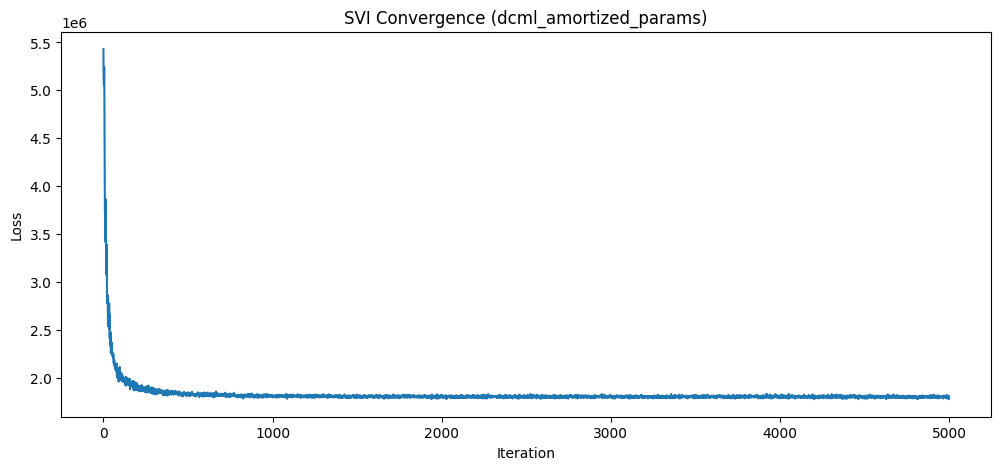

In [58]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=5000, lr=0.1, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

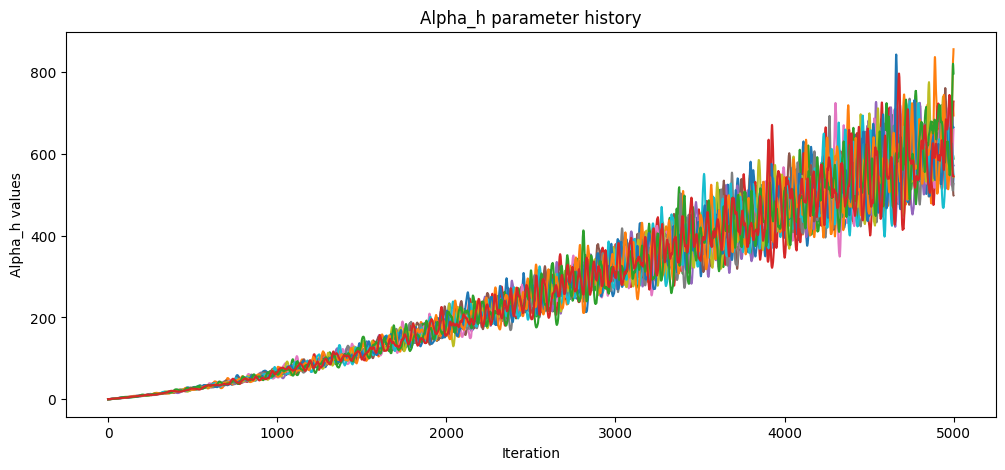

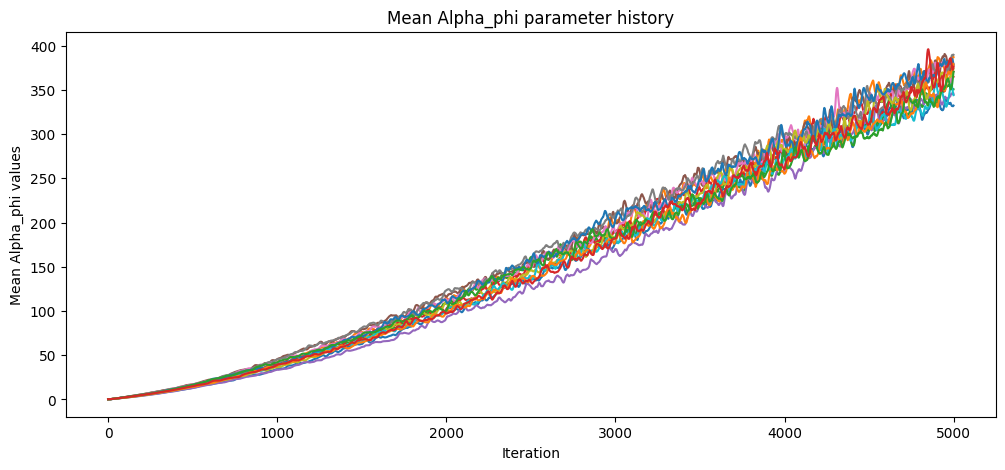

In [59]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

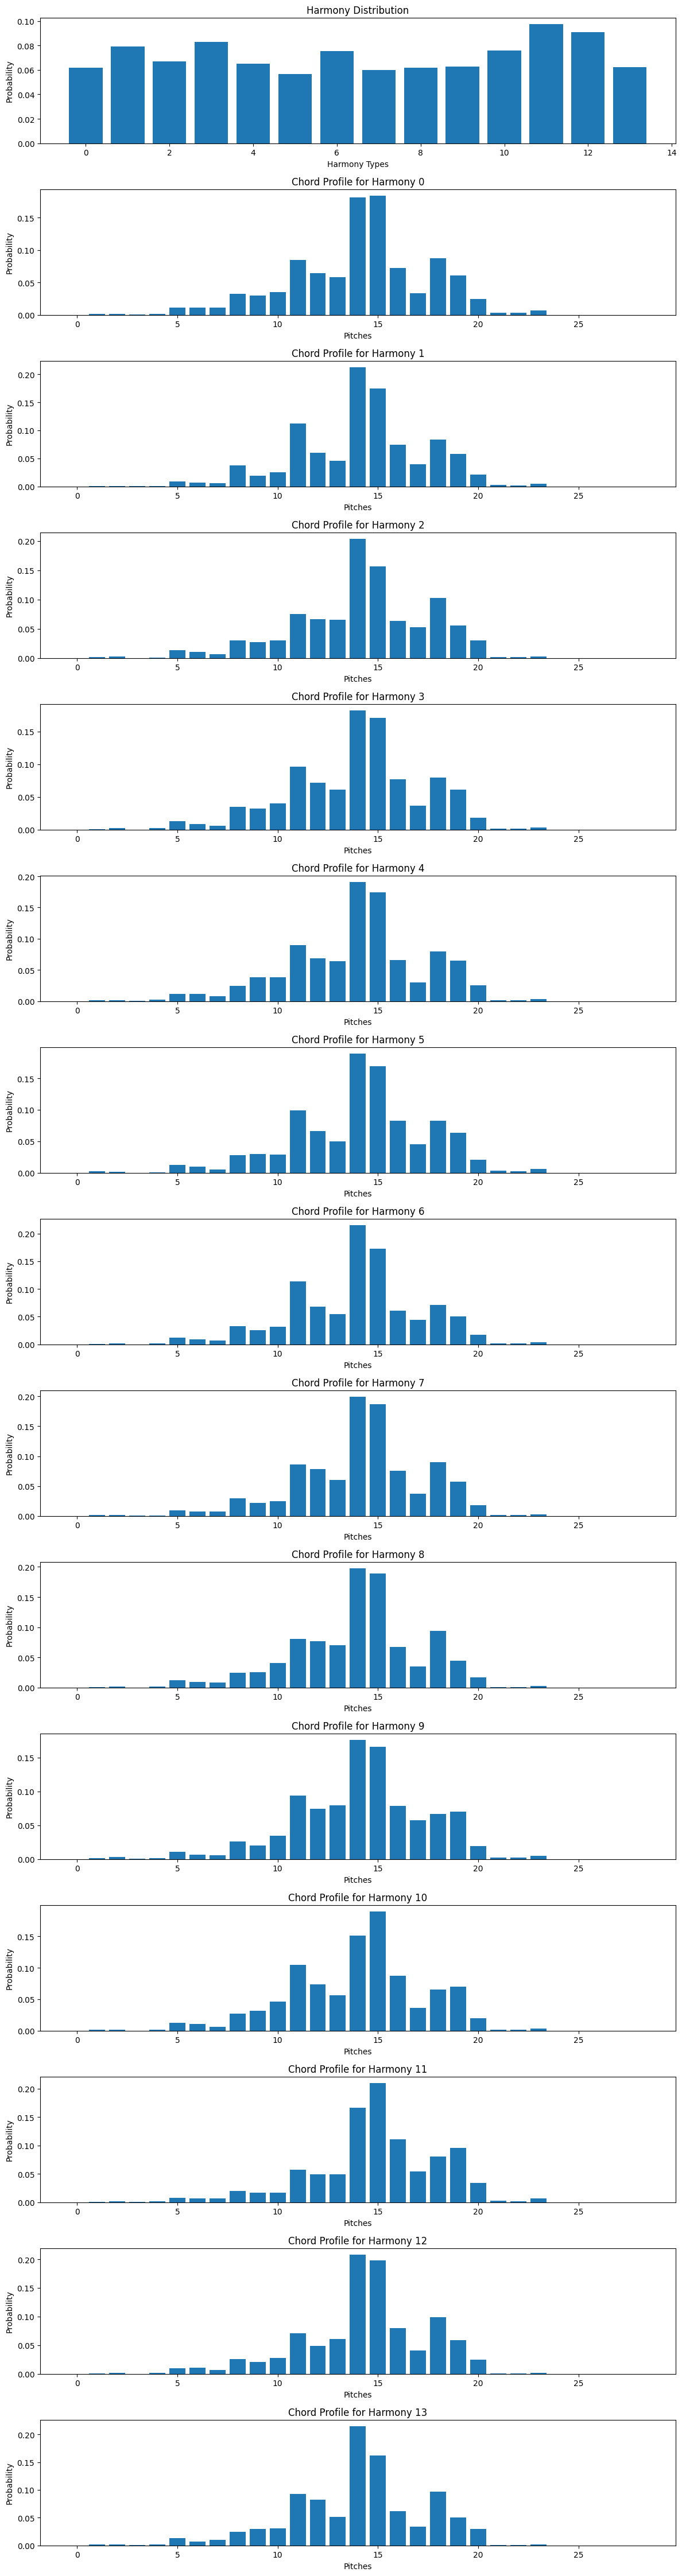

In [60]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")